In [4]:
cluster = Nodes(10)

Nodes([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10)

In [5]:
unionfind!(cluster, 1, 2)
cluster

Nodes([2, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9)

In [6]:
unionfind!(cluster, 2, 3)
cluster

Nodes([2, 3, 3, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 8)

In [7]:
unionfind!(cluster, 3, 4)
cluster

Nodes([2, 3, 4, 4, 5, 6, 7, 8, 9, 10], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7)

In [8]:
connected(cluster, 1, 5)

false

# Graph 

In [1]:
include("perc.jl")
using LightGraphs
using GraphIO
using Statistics
using Plots
using BenchmarkTools

In [3]:
g = loadgraph("data/iceland.lnk", GraphIO.EdgeList.EdgeListFormat())
g = SimpleGraph(g)

num_simulation = 10_000;

In [10]:
function run_site_percolation(num_simulation)
    result = zeros(Int, nv(g))

    for _ in 1:num_simulation
        result = result .+ ssite_percolation(g)
    end
    return result
end

run_site_percolation (generic function with 1 method)

In [17]:
result = @btime run_site_percolation(num_simulation)

BenchmarkTools.Trial: 
  memory estimate:  42.42 MiB
  allocs estimate:  70001
  --------------
  minimum time:     305.849 ms (0.33% GC)
  median time:      328.579 ms (0.31% GC)
  mean time:        327.528 ms (0.31% GC)
  maximum time:     358.399 ms (0.39% GC)
  --------------
  samples:          16
  evals/sample:     1

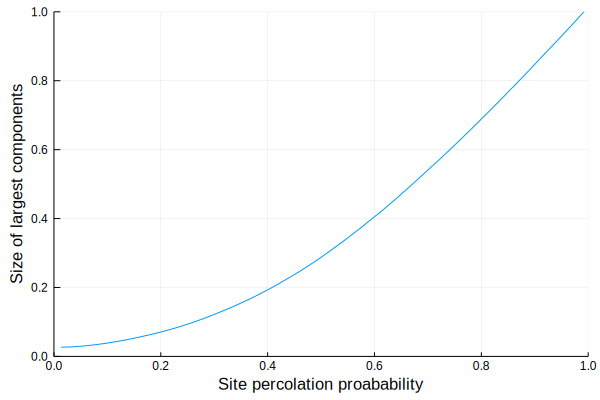

In [18]:
p = collect(1:nv(g)) / nv(g)
CC = result / (num_simulation * nv(g))

plot(p, CC, ylabel="Size of largest components", xlabel="Site percolation proabability", leg=false)
ylims!(0.0, 1.0)
xlims!(0.0, 1.0)

In [4]:
function run_bond_percolation(num_simulation)
    result = zeros(Int, ne(g))
    for _ in 1:num_simulation
        result = result .+ bond_percolation(g)
    end
    return result
end

run_bond_percolation (generic function with 1 method)

In [11]:
result = @btime run_bond_percolation(num_simulation);

  296.344 ms (120001 allocations: 74.62 MiB)


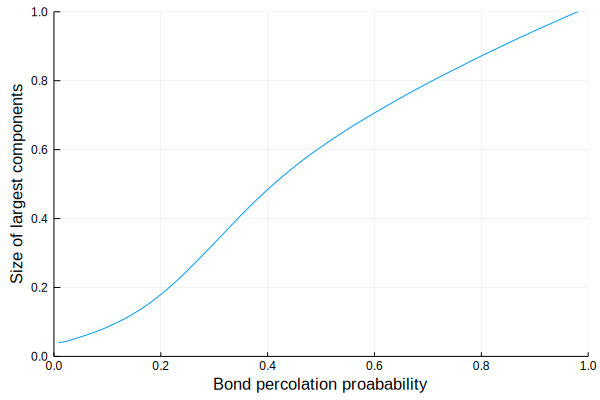

In [12]:
p = collect(1:ne(g)) / ne(g)
CC = result / (num_simulation * nv(g))

plot(p, CC, ylabel="Size of largest components", xlabel="Bond percolation proabability", leg=false)
ylims!(0.0, 1.0)
xlims!(0.0, 1.0)